# **Lab 6: Convolutional Neural Networks**
### Authors: Will Lahners, Edward Powers, and Nino Castellano

## **Describing the Data**

Dataset: https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset/data

## Preparation (3 points total)

> [1.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.


In [20]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import cv2
import numpy as np
import matplotlib.pyplot as plt  

data = {'path': [], 'label': []}

# Define the root path of our dataset
root_path = "Car-Bike-Dataset"

# Get the subfolders (Car and Bike)
folders = os.listdir(root_path)
for folder in folders:
    folder_path = os.path.join(root_path, folder)
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data['path'].append(file_path)
        data['label'].append(folder)

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Encode labels using LabelEncoder (Car: 0, Bike: 1)
le = LabelEncoder()
df['class'] = le.fit_transform(df['label'])

# Shuffle the DataFrame
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Define image size for resizing
h, w = 100, 100

# Create a list to store resized and grayscaled images
table_data = []

# Iterate through each image
for i, row in shuffled_df.iterrows():
    img_path = row['path']
    img = cv2.imread(img_path)
    res_img = cv2.resize(img, dsize=(h, w))
    gray_img = cv2.cvtColor(res_img, cv2.COLOR_BGR2GRAY)
    gray_img_with_channel = np.expand_dims(gray_img, axis=-1)  
    table_data.append(gray_img_with_channel) 

# Convert the image data to a NumPy array
X = np.array(table_data)
y = shuffled_df['class']
labels = shuffled_df['label']

# Code credit to us


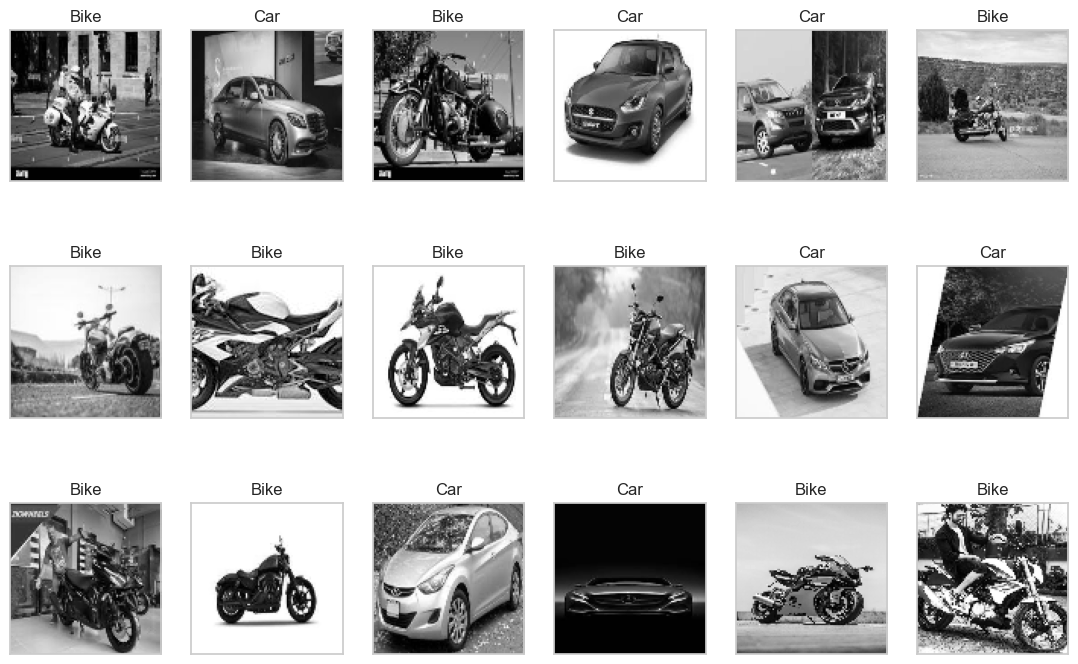

In [21]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of images"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# Assuming labels is a list of 'Car' and 'Bike' labels
plot_gallery(X, labels, h, w)

# Code credit to us

> [1.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

A stratified K-fold cross-validation with K=10 offers a robust and realistic approach to evaluating the performance of our car vs. bike classification model. It ensures that the model is tested on diverse data, reflects the real-world scenario of encountering a continuous stream of images, and mitigates potential biases due to class imbalances.

In [22]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf

# Define the number of folds and batch size
k = 10
batch_size = 128

# Create a StratifiedKFold object
skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store the datasets for each fold
train_datasets = []
test_datasets = []

# Create datasets for each fold
for train_index, test_index in skfold.split(X, y):
    # Split data into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create TensorFlow datasets
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_train = ds_train.batch(batch_size).prefetch(batch_size)
    train_datasets.append(ds_train)

    ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    ds_test = ds_test.batch(batch_size).prefetch(batch_size)
    test_datasets.append(ds_test)

## Modeling (6 points total)

> [1.5 points]  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You should make use of Keras augmentation layers, like in the class examples.

> [2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures and investigate changing one or more parameters of each architecture such as the number of filters. This means, at a  minimum, you will train a total of four models (2 different architectures, with 2 parameters changed in each architecture). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 

**Architecture 1: Baseline CNN**

*Model 1A (Baseline):*
Convolutional Layers: 2 layers with 32 filters each, (3, 3) kernel size
Dense Layer: 128 units
Dropout: 0.5
*Model 1B (More Filters):*
Convolutional Layers: 2 layers with 64 filters each, (3, 3) kernel size
Dense Layer: 128 units
Dropout: 0.5

**Architecture 2: ResNet**

*Model 2A (Basic ResNet):*
Similar to the ResNet example provided in class, with 2 residual blocks.
Filters: 32 in the initial layers, 64 in the residual blocks.
Dense Layer: 256 units
Dropout: 0.25 before the dense layer, 0.5 before the output layer.
*Model 2B (Deeper ResNet):*
Add one more residual block to Model 2A, increasing the network depth.
Keep the filter sizes and dense layer configuration the same.
Dropout: 0.25 before each dense layer.

### **Model 1A:** (3, 3) kernel size, 32 filters each

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Define the model
model = Sequential()

# Data Augmentation Layers
model.add(RandomFlip("horizontal"))
model.add(RandomRotation(0.1))
model.add(RandomZoom(0.1))
model.add(RandomContrast(0.1))

# Convolutional Layers
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(h, w, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

# Classification Layers
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))  # Output layer

# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

c:\Users\ncast\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [24]:
# Lists to store metrics for each fold
fold_f1_scores = []
fold_histories = []

# Iterate through the folds
for fold, (ds_train, ds_test) in enumerate(zip(train_datasets, test_datasets)):
    # Train the model
    print(f"Training for Fold {fold+1}")
    history = model.fit(ds_train, epochs=10, validation_data=ds_test, verbose=1)

    # Evaluate on the test set
    _, accuracy, precision, recall, auc = model.evaluate(ds_test, verbose=0)
    f1_score = 2 * (precision * recall) / (precision + recall)
    fold_f1_scores.append(f1_score)
    fold_histories.append(history)

Training for Fold 1
Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5118 - auc: 0.5007 - loss: 91.4241 - precision: 0.4949 - recall: 0.5356 - val_accuracy: 0.7075 - val_auc: 0.7774 - val_loss: 0.5754 - val_precision: 0.7293 - val_recall: 0.6600
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - accuracy: 0.7337 - auc: 0.7915 - loss: 0.5616 - precision: 0.7455 - recall: 0.6836 - val_accuracy: 0.8125 - val_auc: 0.9502 - val_loss: 0.4510 - val_precision: 0.9771 - val_recall: 0.6400
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step - accuracy: 0.8460 - auc: 0.9144 - loss: 0.3847 - precision: 0.8638 - recall: 0.8097 - val_accuracy: 0.8675 - val_auc: 0.9461 - val_loss: 0.3042 - val_precision: 0.8731 - val_recall: 0.8600
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 277ms/step - accuracy: 0.8631 - auc: 0.9275 - loss: 0.3580 - precision: 0.8717 - recall: 0.8419 - val_accuracy: 0.8725 - val_auc: 0.9594 - val_loss: 0.3586 - val_precision: 0.9461 - val_recall: 0.7900
Epoch 5/10
29

KeyboardInterrupt: 

In [ ]:
# Calculate average accuracy and loss across folds
avg_accuracy = np.mean([h.history['accuracy'] for h in fold_histories], axis=0)
avg_val_accuracy = np.mean([h.history['val_accuracy'] for h in fold_histories], axis=0)
avg_loss = np.mean([h.history['loss'] for h in fold_histories], axis=0)
avg_val_loss = np.mean([h.history['val_loss'] for h in fold_histories], axis=0)

# Plot the average curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(avg_accuracy, label='Average Training Accuracy')
plt.plot(avg_val_accuracy, label='Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### **Model 1B:** (3, 3) kernel size, 64 filters each

In [ ]:
# Define the model
model2 = Sequential()

# Data Augmentation Layers
model2.add(RandomFlip("horizontal"))
model2.add(RandomRotation(0.1))
model2.add(RandomZoom(0.1))
model2.add(RandomContrast(0.1))

# Convolutional Layers
model2.add(Conv2D(64, (3, 3), activation="relu", input_shape=(h, w, 1)))  
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation="relu")) 
model2.add(MaxPooling2D((2, 2)))

# Classification Layers
model2.add(Flatten())
model2.add(Dense(128, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation="sigmoid"))  # Output layer

# Compile the model
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [ ]:
# Lists to store metrics for each fold
model2_fold_f1_scores = []
model2_fold_histories = []

# Iterate through the folds
for fold, (ds_train, ds_test) in enumerate(zip(train_datasets, test_datasets)):
    # Train the model
    print(f"Training for Fold {fold+1}")
    history = model2.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=1)

    # Evaluate on the test set
    _, accuracy, precision, recall, auc = model2.evaluate(ds_test, verbose=0)
    f1_score = 2 * (precision * recall) / (precision + recall)
    model2_fold_f1_scores.append(f1_score)
    model2_fold_histories.append(history)

In [ ]:
# Calculate average accuracy and loss across folds
avg_accuracy = np.mean([h.history['accuracy'] for h in model2_fold_histories], axis=0)
avg_val_accuracy = np.mean([h.history['val_accuracy'] for h in model2_fold_histories], axis=0)
avg_loss = np.mean([h.history['loss'] for h in model2_fold_histories], axis=0)
avg_val_loss = np.mean([h.history['val_loss'] for h in model2_fold_histories], axis=0)

# Plot the average curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(avg_accuracy, label='Average Training Accuracy')
plt.plot(avg_val_accuracy, label='Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### **Model 2A:** ResNet with 2 residual blocks

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Add, 
                                     Activation, Flatten, Dense, Dropout,
                                     RandomFlip, RandomRotation, RandomZoom, RandomContrast)

# Define input shape and hyperparameters
h, w, l = 100, 100, 1  # Image dimensions and channels (grayscale)
filters_initial = 32
filters_residual = 64

# Define the input layer
input_layer = Input(shape=(h, w, l))

# Data Augmentation
x = RandomFlip("horizontal")(input_layer)
x = RandomRotation(0.1)(x)
x = RandomZoom(0.1)(x)
x = RandomContrast(0.1)(x)

# Initial Convolutional Layer
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)  # Use 64 filters
x = MaxPooling2D((2, 2))(x)

# Residual Block 1
shortcut1 = x  # Save the input to the residual block
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters_residual, (3, 3), padding="same")(x)
x = Add()([x, shortcut1])  # Add the residual connection
x = Activation("relu")(x)

# Residual Block 2
shortcut2 = x
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters_residual, (3, 3), padding="same")(x)
x = Add()([x, shortcut2])
x = Activation("relu")(x)

# Classification Layers
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation="sigmoid")(x)

# Create the ResNet model
model2A = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model2A.compile(loss="binary_crossentropy", optimizer="adam", 
                 metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [20]:
# Lists to store metrics for each fold
model2A_fold_f1_scores = []
model2A_fold_histories = []

# Number of epochs (adjust as needed)
epochs = 10 

# Iterate through the folds
for fold, (ds_train, ds_test) in enumerate(zip(train_datasets, test_datasets)):
    # Train the model
    print(f"Training for Fold {fold+1}")
    history = model2A.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=1)

    # Evaluate on the test set
    _, accuracy, precision, recall, auc = model2A.evaluate(ds_test, verbose=0)
    f1_score = 2 * (precision * recall) / (precision + recall)
    model2A_fold_f1_scores.append(f1_score)
    model2A_fold_histories.append(history)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 347ms/step - accuracy: 0.5015 - loss: 0.5226 - val_accuracy: 0.5000 - val_loss: 0.5293
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - accuracy: 0.5098 - loss: 0.5182 - val_accuracy: 0.5000 - val_loss: 0.5241
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.5098 - loss: 0.5133 - val_accuracy: 0.5000 - val_loss: 0.5201
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.5098 - loss: 0.5096 - val_accuracy: 0.5000 - val_loss: 0.5172
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.5098 - loss: 0.5068 - val_accuracy: 0.5000 - val_loss: 0.5149
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step - accuracy: 0.5098 - loss: 0.5046 - val_accuracy: 0.5000 - val_loss: 0.5131
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - accuracy: 0.5098 - loss: 0.5030 - val_accuracy: 0.5000 - val_loss: 0.5118
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.5098 - loss: 0.5017 - val_accuracy: 

Text(0.5, 0, 'epochs')

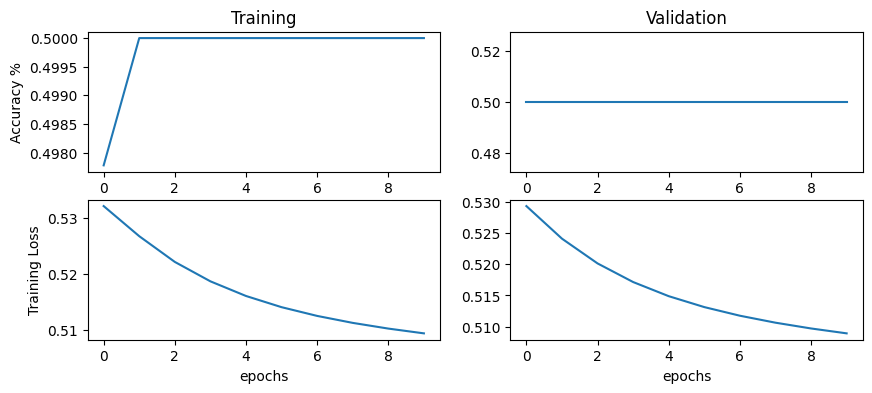

In [43]:
# Calculate average accuracy and loss across folds
avg_accuracy = np.mean([h.history['accuracy'] for h in model2A_fold_histories], axis=0)
avg_val_accuracy = np.mean([h.history['val_accuracy'] for h in model2A_fold_histories], axis=0)
avg_loss = np.mean([h.history['loss'] for h in model2A_fold_histories], axis=0)
avg_val_loss = np.mean([h.history['val_loss'] for h in model2A_fold_histories], axis=0)

# Plot the average curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(avg_accuracy, label='Average Training Accuracy')
plt.plot(avg_val_accuracy, label='Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### **Model 2B:** ResNet with 3 residual blocks

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Add, 
                                     Activation, Flatten, Dense, Dropout,
                                     RandomFlip, RandomRotation, RandomZoom, RandomContrast)

# Define input shape and hyperparameters
h, w, l = 100, 100, 1  # Image dimensions and channels (grayscale)
filters_initial = 32
filters_residual = 64

# Define the input layer
input_layer = Input(shape=(h, w, l))

# Data Augmentation
x = RandomFlip("horizontal")(input_layer)
x = RandomRotation(0.1)(x)
x = RandomZoom(0.1)(x)
x = RandomContrast(0.1)(x)

# Initial Convolutional Layer
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)  # Use 64 filters
x = MaxPooling2D((2, 2))(x)

# Residual Block 1
shortcut1 = x  # Save the input to the residual block
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters_residual, (3, 3), padding="same")(x)
x = Add()([x, shortcut1])  # Add the residual connection
x = Activation("relu")(x)

# Residual Block 2
shortcut2 = x
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters_residual, (3, 3), padding="same")(x)
x = Add()([x, shortcut2])
x = Activation("relu")(x)

# *** Additional Residual Block 3 ***
shortcut3 = x
x = Conv2D(filters_residual, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(filters_residual, (3, 3), padding="same")(x)
x = Add()([x, shortcut3])
x = Activation("relu")(x)

# Classification Layers (modified dropout)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.25)(x)  # Dropout before the first dense layer
x = Dense(256, activation="relu")(x)
x = Dropout(0.25)(x)  # Dropout before the output layer
output_layer = Dense(1, activation="sigmoid")(x)

# Create the ResNet model
model2B = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model2B.compile(loss="binary_crossentropy", optimizer="adam", 
                 metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])


In [47]:
# Lists to store metrics for each fold
model2B_fold_f1_scores = []
model2B_fold_histories = []

# Number of epochs (adjust as needed)
epochs = 10 

# Iterate through the folds
for fold, (ds_train, ds_test) in enumerate(zip(train_datasets, test_datasets)):
    # Train the model
    print(f"Training for Fold {fold+1}")
    history = model2B.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=1)

    # Evaluate on the test set
    _, accuracy, precision, recall, auc = model2B.evaluate(ds_test, verbose=0)
    f1_score = 2 * (precision * recall) / (precision + recall)
    model2B_fold_f1_scores.append(f1_score)
    model2B_fold_histories.append(history)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 432ms/step - accuracy: 0.4927 - loss: 0.5230 - val_accuracy: 0.5000 - val_loss: 0.5304
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - accuracy: 0.5085 - loss: 0.5197 - val_accuracy: 0.5000 - val_loss: 0.5263
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.5210 - loss: 0.5002 - val_accuracy: 0.5000 - val_loss: 0.5233
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.4904 - loss: 0.4341 - val_accuracy: 0.4950 - val_loss: 0.5251
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.4880 - loss: 0.2714 - val_accuracy: 0.5000 - val_loss: 0.5201
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - accuracy: 0.5282 - loss: 0.2692 - val_accuracy: 0.5650 - val_loss: 0.4431
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.5193 - loss: 0.2680 - val_accuracy: 0.5650 - val_loss: 0.4464
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - accuracy: 0.5184 - loss: 0.2658 - val_accuracy: 0

> [1.5 points] Visualize the final results of all the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models. 

> [1 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

## Exceptional Work (1 points total)

For our exceptional work, we wanted to create another model using the Ensemble architecture discussed in class. This is another complex architecture (similar to the ResNet architecture), so we were interested to see whether it would have the same difficulties ResNet did or would it perform similar to or better than our best CNN model from above.

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define base CNN models
def create_base_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Train base models
base_models = []
base_models_history = []  # To store training history

for train_dataset in train_datasets:
    base_model = create_base_model((h, w, 1))
    base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    base_model.fit(train_dataset, epochs=10)  # You may adjust the number of epochs
    base_models.append(base_model)
    base_models_history.append(history)

# Combine predictions
def ensemble_predict(base_models, X):
    predictions = []
    for base_model in base_models:
        prediction = base_model.predict(X)
        predictions.append(prediction)
    return np.mean(predictions, axis=0)  # Ensemble by averaging predictions

# Evaluate ensemble performance
def evaluate_ensemble(base_models, test_datasets):
    accuracies = []
    for base_model, test_dataset in zip(base_models, test_datasets):
        _, accuracy = base_model.evaluate(test_dataset)
        accuracies.append(accuracy)
    return np.mean(accuracies)

ensemble_accuracy = evaluate_ensemble(base_models, test_datasets)
print("Ensemble Accuracy:", ensemble_accuracy)


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 631ms/step - accuracy: 0.5474 - loss: 27.7427
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 330ms/step - accuracy: 0.7246 - loss: 0.7084
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 304ms/step - accuracy: 0.8375 - loss: 0.3760
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 302ms/step - accuracy: 0.9037 - loss: 0.2428
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 290ms/step - accuracy: 0.9255 - loss: 0.1900
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - accuracy: 0.9381 - loss: 0.1427
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 295ms/step - accuracy: 0.9439 - loss: 0.1387
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 308ms/step - accuracy: 0.9537 - loss: 0.1160
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - accuracy: 0.9548 - loss: 0.1178
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 285ms/step - accuracy: 0.9695 - loss: 0.0838
Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 317ms/step - accuracy: 0.5230 - loss: 17.9744
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 306ms/s

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


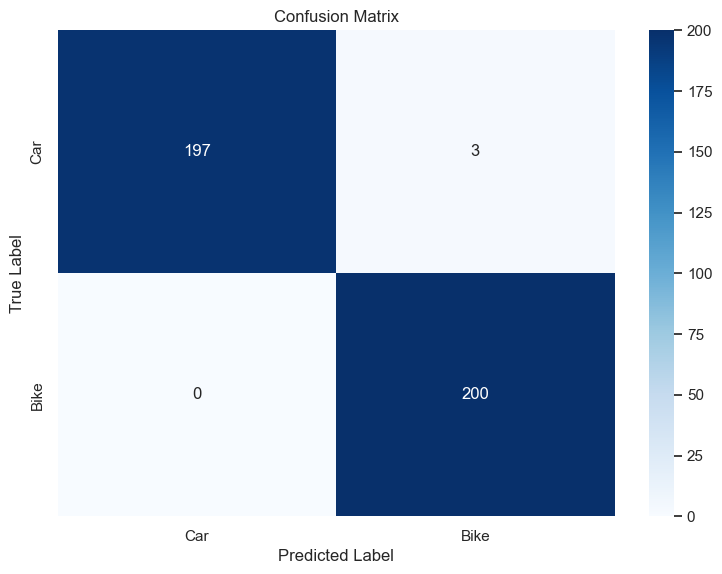

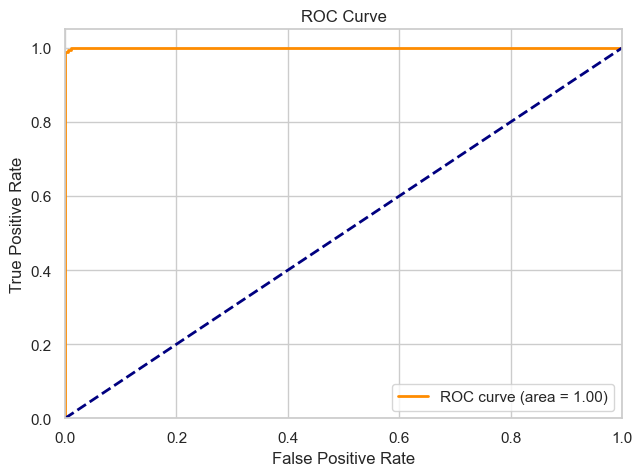

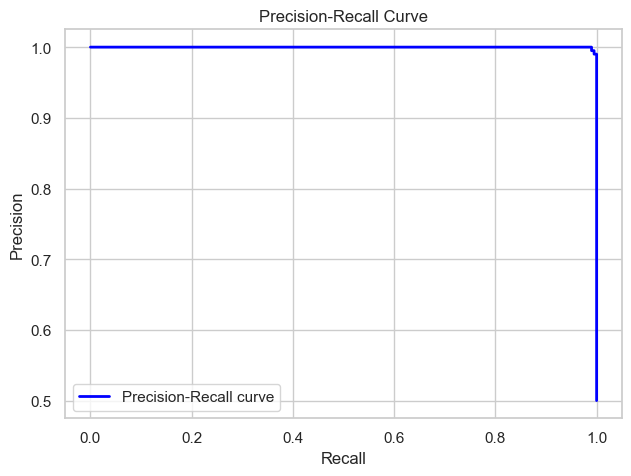

NameError: name 'base_models_history' is not defined

In [27]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Plot Training History
def plot_training_history(base_models_history):
    plt.figure(figsize=(12, 6))
    for i, history in enumerate(base_models_history):
        plt.subplot(1, len(base_models_history), i+1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['loss'], label='Training Loss')
        plt.title('Model {}'.format(i+1))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy/Loss')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# ROC Curve and AUC
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

# Assuming you have predictions from ensemble_predict function
y_pred = ensemble_predict(base_models, X_test)
plot_confusion_matrix(y_test, np.round(y_pred), ['Car', 'Bike'])
plot_roc_curve(y_test, y_pred)
plot_precision_recall_curve(y_test, y_pred)
plot_training_history(base_models_history)